C:\UserData\takuyai\Miniconda3\envs\lith_nlp\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


41 Unique LithCodes that are not UNKN or numeric
['GRVL' 'CLAY' 'CRSE' 'SHLE' 'BSLT' 'ROCK' 'SAND' 'SOIL' 'GRNT' 'SASH'
 'CGLM' 'SDSN' 'TPSL' 'BLBN' 'COAL' 'SILT' 'LMSN' 'ALVM' 'QRTZ' 'SDCY'
 'LOAM' 'BLDR' 'SLTE' 'SLCY' 'BNST' 'VLCC' 'SLSN' 'BRBN' 'GRBN' 'MDSN'
 'WB' 'TUFF' 'BDRK' 'SNDY' 'SDMN' 'CVTY' 'CLBD' 'FILL' 'DLMT' 'WODY'
 'FINE']
Attempting to fill in 99 unknown MajorLithCode based on provided descriptions


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:33<00:00,  2.98it/s]


After clean up 40 unique LithCodes that are not UNKN or numeric
['GRVL' 'CLAY' 'CRSE' 'SHLE' 'BSLT' 'ROCK' 'SAND' 'SOIL' 'TPSL' 'GRNT'
 'SASH' 'CGLM' 'SDSN' 'COAL' 'SILT' 'LMSN' 'ALVM' 'QRTZ' 'SDCY' 'LOAM'
 'BLDR' 'SLTE' 'SLCY' 'VLCC' 'SLSN' 'BRBN' 'GRBN' 'MDSN' 'WB' 'TUFF'
 'BDRK' 'SNDY' 'SDMN' 'CVTY' 'CLBD' 'FILL' 'DLMT' 'WODY' 'BNST' 'FINE']
(1000,) (1000,)
Number of entries 1000
Dictionary(139 unique tokens: ['bear', 'cement', 'gravel', 'water', 'clay']...)


notebook_setup.ipynb:6: UserWarning: WARNING - Filtering to unique LithCode and Description, which may not be desirable in future!
  "metadata": {},


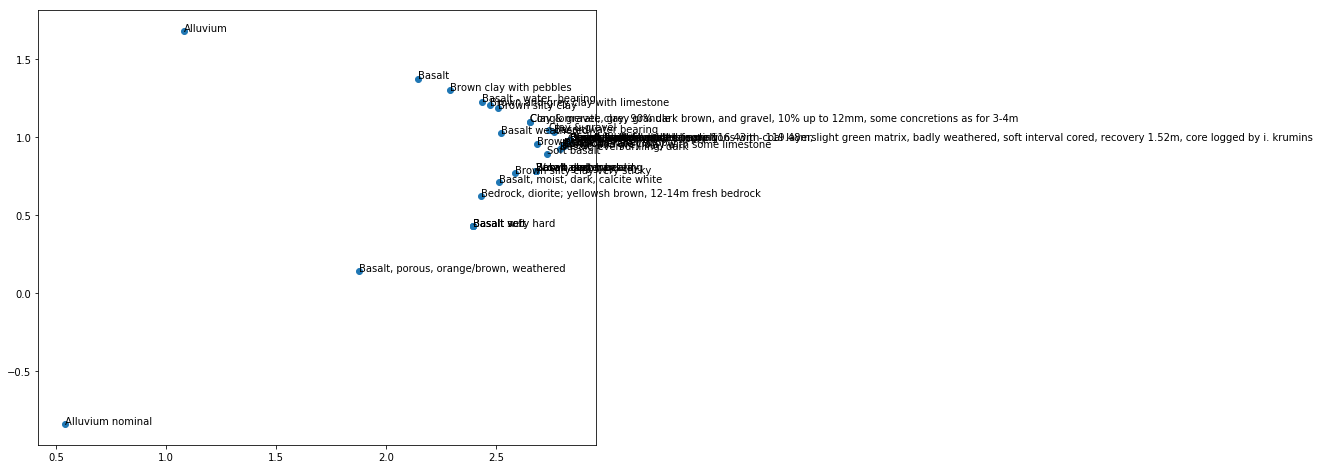

In [1]:
%run notebook_setup.ipynb

Let's see what AffinityPropagation looks like...

Some useful links:
* http://www.psi.toronto.edu/affinitypropagation/faq.html
* https://stackoverflow.com/questions/47153203/cluster-word2vec-vectors-using-affinity-propagation-in-python-sklearn
* https://stackoverflow.com/questions/35494458/affinity-propagation-in-python
* http://blog.christianperone.com/2013/09/machine-learning-cosine-similarity-for-vector-space-models-part-iii/
* https://towardsdatascience.com/introduction-to-text-representation-and-similarity-b5dd3fd71737

AffinityPropagation can use similarity (rather than distances).

In [2]:
cache = {}  # cache store for description string filtered to nouns only

temp_df = lith_code_desc.reset_index(drop=True)  # need numeric index

nrow, ncol = len(temp_df.index), len(temp_df.index)
token_sim = np.empty((nrow, ncol), dtype=np.float64)
exemplars = np.empty((nrow, ncol), dtype=np.float64)

def filter_description(text, stopwords):
    tmp = text.split('-')[0]
    return get_nouns(tokenize_and_stem(tmp.strip(), stopwords))

for row in temp_df.itertuples():   
    if row.Index in cache:
        outer_stemmed = cache[row.Index]
    else:
        outer_stemmed = filter_description(row.Description, stopwords)
    # End if

    for row2 in temp_df.itertuples():
        if row2.Index in cache:
            inner_stemmed = cache[row2.Index]
        else:
            inner_stemmed = filter_description(row2.Description, stopwords)
            cache[row2.Index] = inner_stemmed
        # End if

        # Calculate similarity score
        score = calc_similarity_score(outer_stemmed, inner_stemmed)
        token_sim[row.Index, row2.Index] = score

        # Larger values for the given description increase chance that it will be selected as an exemplar
        # may or may not be useful...
        if len(outer_stemmed) < 3:
            exemplars[row.Index, row2.Index] = 1.0
        else:
            if len(outer_stemmed) > 5:
                exemplars[row.Index, row2.Index] = 0.0
            else:
                exemplars[row.Index, row2.Index] = 0.5
            # End if
        # End if
        
    # End for

# End for

In [3]:
print("If using amalgamated example dataset, this should be around 560 entries:", len(lith_code_desc.index))

If using amalgamated example dataset, this should be around 560 entries: 560


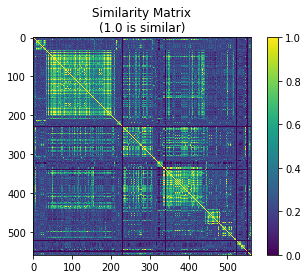

In [4]:
plt.imshow(token_sim)
plt.colorbar()
plt.title('Similarity Matrix\n(1.0 is similar)');

In [5]:
from sklearn.manifold import MDS

# Cast to 2D space
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=5)
pos = mds.fit_transform(1 - token_sim)

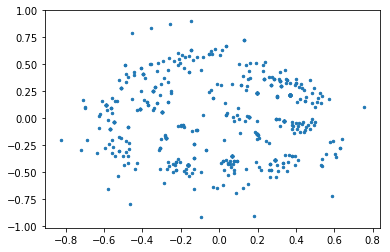

In [6]:
plt.scatter(pos[:, 0], pos[:, 1], s=6);

In [7]:
from sklearn.metrics.pairwise import cosine_similarity

# Convert to cosine similarity matrix
# , preference=-np.mean(exemplars)
cos_sim = cosine_similarity(pos)
ap_model = sklearn.cluster.AffinityPropagation(damping=0.56, affinity="precomputed")
ap_model.fit(cos_sim)

AffinityPropagation(affinity='precomputed', convergence_iter=15, copy=True,
          damping=0.56, max_iter=200, preference=None, verbose=False)

In [8]:
cluster_centers_idx = ap_model.cluster_centers_indices_
labels = ap_model.labels_
unique_labels = np.unique(labels)
n_clusters_ = len(cluster_centers_idx)
print("Num clusters:", n_clusters_)

Num clusters: 67


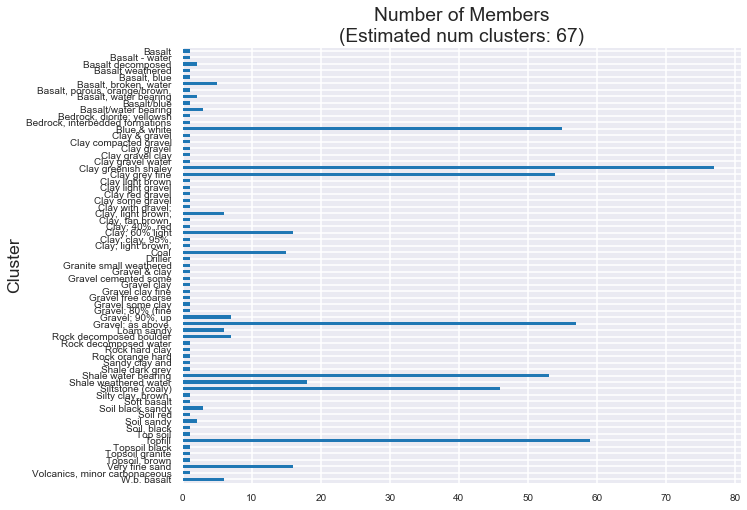

In [9]:
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("poster")

cluster_data = {}
for k in range(n_clusters_):
    class_members = labels == k
    
    cluster_size = len(class_members[class_members == True])
    exemplar = lith_desc[cluster_centers_idx[k]]
    exemplar = ' '.join(exemplar.split()[0:3])
    cluster_data[exemplar] = cluster_size
# End for

fig, ax = plt.subplots(figsize=(10,8))
clustered_info = pd.DataFrame.from_dict(cluster_data, orient='index')
clustered_info.index.name = 'Cluster'
clustered_info.columns = ['Members']
clustered_info.sort_index(ascending=False, inplace=True)
clustered_info.plot(kind='barh', fontsize=10, title=f'Number of Members\n(Estimated num clusters: {n_clusters_})', 
                    legend=False, ax=ax);

In [10]:
# Write out results to csv
res = {}

for cluster_id in unique_labels:
    exemplar = lith_desc[cluster_centers_idx[cluster_id]]
    cluster = np.unique(lith_desc[np.nonzero(labels == cluster_id)[0]])
    res[exemplar] = " | ".join(cluster)
# End for

res_df = pd.DataFrame([i for i in res.values()], index=res.keys(), columns=["Matches"])
res_df.index.name = "Exemplar"

try:
    res_df.to_csv("eg_output.csv", index=True)
except PermissionError:
    raise PermissionError("ERROR OCCURRED - csv file is probably open in Excel. Close Excel and try again.")
# End try

assert len(unique_labels) == len(res_df.index), "Number of clusters do not match outputted cluster exemplars!"

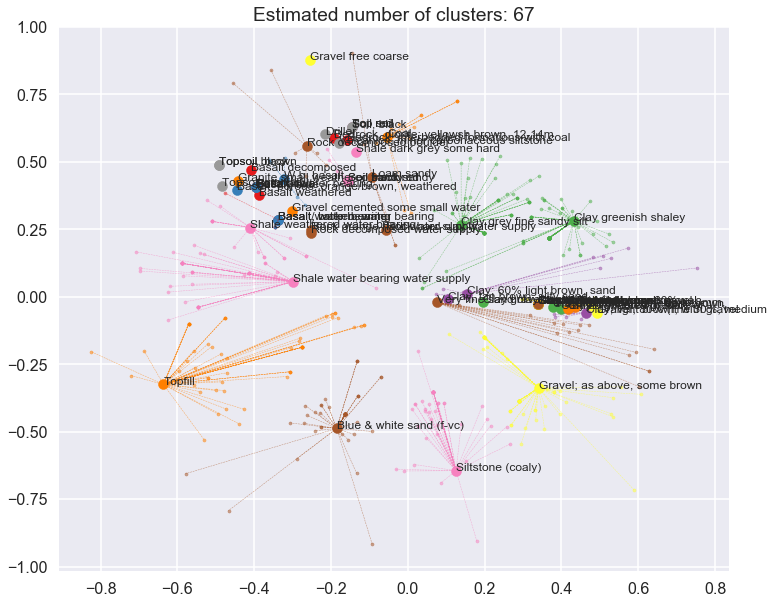

In [11]:
fig, ax = plt.subplots(figsize=(12,10))

cm = plt.get_cmap('Set1')
colors = [cm(1.0*i/n_clusters_) for i in range(n_clusters_)]

count = 0
# for each cluster get all members and plot with same color
for cluster_idx, color in zip(range(n_clusters_), colors):
    in_cluster = labels == cluster_idx
    cluster_set = pos[in_cluster]
    
    cluster_row = cluster_centers_idx[cluster_idx]
    cluster_center = pos[cluster_row]
    
    exemplar = lith_desc[cluster_row]
    
    # Plot cluster exemplar
    ax.scatter(cluster_center[0], cluster_center[1], marker='o', c=color, s=100)
    ax.annotate(" ".join(exemplar.split()[:5]), (cluster_center[0], cluster_center[1]), 
                alpha=1, fontsize=12)
    
    for i, txt in enumerate(lith_desc[in_cluster]):
        if txt == exemplar:
            continue
            
        x, y = cluster_set[i]
        
        # Plot cluster member
        ax.scatter(x, y, marker='o', c=color, alpha=0.5, s=10)
        
        # Plot line between cluster exemplar and member
        plt.plot([cluster_center[0], x], [cluster_center[1], y], c=color, 
                 linestyle='--', linewidth=0.5, alpha=0.6)
        
        # Add text annotation
        # ax.annotate(" ".join(txt.split()[0:3]), (x, y), alpha=0.1)
    # End for
    
# End for

plt.title(f"Estimated number of clusters: {n_clusters_}");